<a href="https://colab.research.google.com/github/Suhaib-AbuRaidah/Intro2ML_Assignments/blob/main/Assignment1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Five Ideas to use a smartphone's sensors to analyze data

**First idea:** Capture an image like a checkerboard for example, and detect the corners using either OpenCV’s built-in corner detectors or a
Harris corner detector implemented with NumPy.

**Second idea:** Record a person speaking outdoors in a windy environment and
apply a high-pass filter to reduce wind noise.

**Third idea:** Capture multiple images of an object from different viewpoints
and identify corresponding points in the images using ORB or SIFT feature
extractors (non-AI based).

**Fourth idea:** Record accelerometer data while moving, integrate and
double-integrate the signals to estimate velocity and distance traveled,
and then apply a PID controller or a Kalman filter for motion tracking.

**Fifth idea:** Measure ambient light sensor (ALS) readings outdoors during
daylight and compare them with reference clear-sky radiance data for the same
time, date, and location to estimate cloudiness. (how cloudy the weather is).

# Implementing the First Idea

The cell below is for importing necessary packages

In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

The cell below is to clone the Github repo containing the image of the checkerboard taken by my phone.

In [2]:
!git clone https://github.com/Suhaib-AbuRaidah/Intro2ML_Assignments.git


Cloning into 'Intro2ML_Assignments'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 33 (delta 4), reused 10 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 1.12 MiB | 12.08 MiB/s, done.
Resolving deltas: 100% (4/4), done.


The cell below is for loading and displaying the image of the checkerboard.

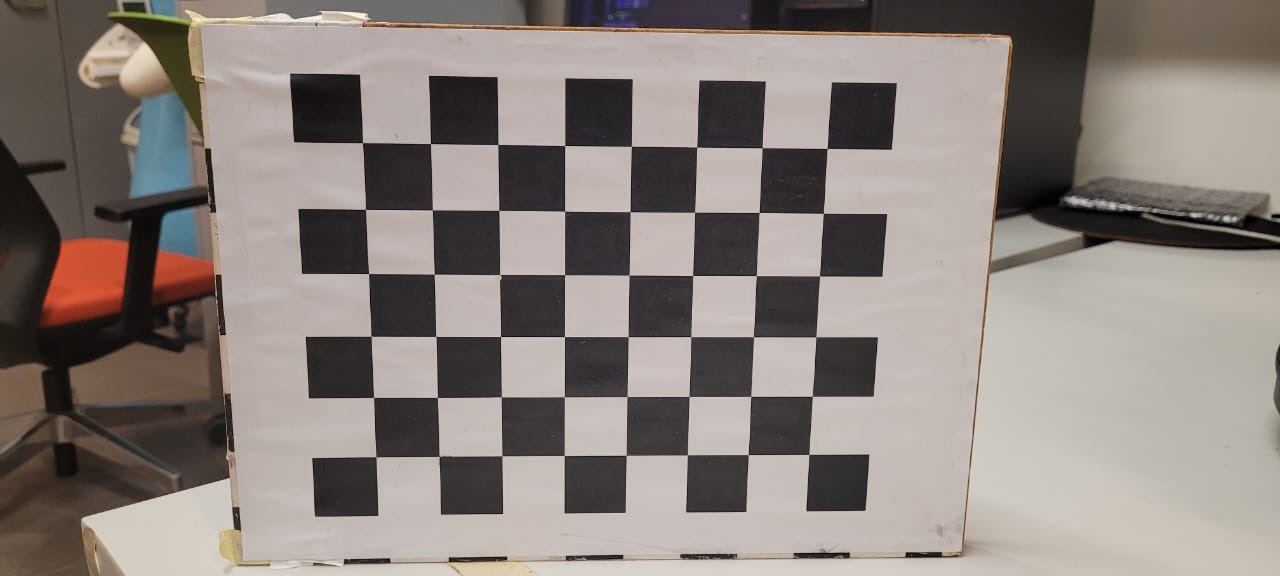

In [3]:
img = cv2.imread("Intro2ML_Assignments/Assignment1/Checkerboard.jpeg")
cv2_imshow(img)

This cell below is for cropping the background from the image and displaying the cropped image.

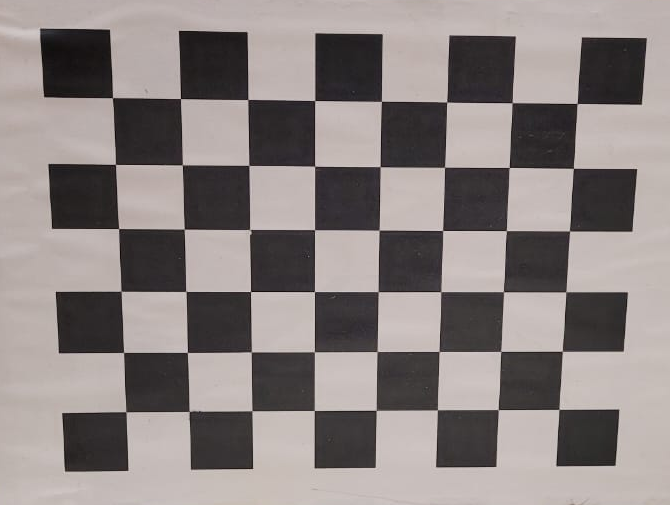

In [4]:
img = img[45:550,250:920]
cv2_imshow(img)

The cell below is for defining the function that does the convolution over the image, necssary for applying the differntiating filter.

In [5]:
def convolve(image, kernel):
    H, W = image.shape
    kH, kW = kernel.shape
    offsetH = kH // 2 # equals 1 for a kernel of shape (3,3), it means that the first and last line will be skipped in the x-dimension.
    offsetW = kW // 2 # The same here, but for the y-dimension.

    output = np.zeros_like(image)
    # looping in the pixels to convolve with the Sobel kernel.
    for i in range(offsetH, H - offsetH):
        for j in range(offsetW, W - offsetW):
            region = image[i - offsetH:i + offsetH + 1, j - offsetW:j + offsetW + 1] # choosing part of the image (3,3) to covolve.
            output[i, j] = np.sum(region * kernel) # pixel-wise multiplication with the kernel and summing the result for each pixel.

    return output

The cell below is for defining the Harris corner detector algorithm function, this algorithm is done from scratch using only numpy.

In [6]:
def harris_corner_detection(image, k=0.04, window_size=3):
    # Load and convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)

    # Define Sobel kernels in x and y dimensions to find the gradient.
    sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=np.float64)

    sobel_y = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]], dtype=np.float64)

    # Compute image gradients using convolve function with Sobel kernels
    Ix = convolve(gray, sobel_x)
    Iy = convolve(gray, sobel_y)

    # Compute products of derivatives
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    # Define window size
    kernel = np.ones((window_size, window_size))

    # Convolve with window of ones.
    Sxx = convolve(Ixx, kernel)
    Syy = convolve(Iyy, kernel)
    Sxy = convolve(Ixy, kernel)

    # Compute Harris response
    detM = (Sxx * Syy)-(Sxy ** 2)
    traceM = Sxx + Syy
    R = detM - k * ((traceM/2) ** 2) # R is the Harris response of the image
    image[R>0.01*R.max()]= [0,0,255] # Find the corners by comparing Harris response to a threshold of [0.01*R.max()]
    # Show the image
    cv2_imshow(image)

    return image

The cell below is for defining the function to use the built-in Open-CV Harris corner detector function. It is used as a baseline for the algorithm in the cell above.

In [7]:
def built_in_harris(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, 2, 3, 0.1)
    dst = cv2.dilate(dst, None)
    image[dst > 0.01*dst.max()] = [0, 0, 255]
    cv2_imshow(image)

The cell below is for applying the built-in Harris corner detector in the Open-CV library on the image. (The red dots are clearly the corners)

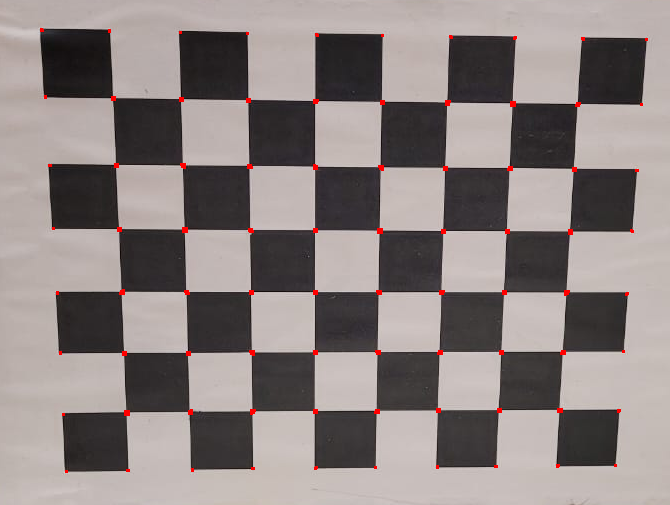

In [8]:
img_built_in = np.copy(img)
built_in_harris(img_built_in)

The cell below is for applying the Harris detector algorithm implemented using numpy on the image.

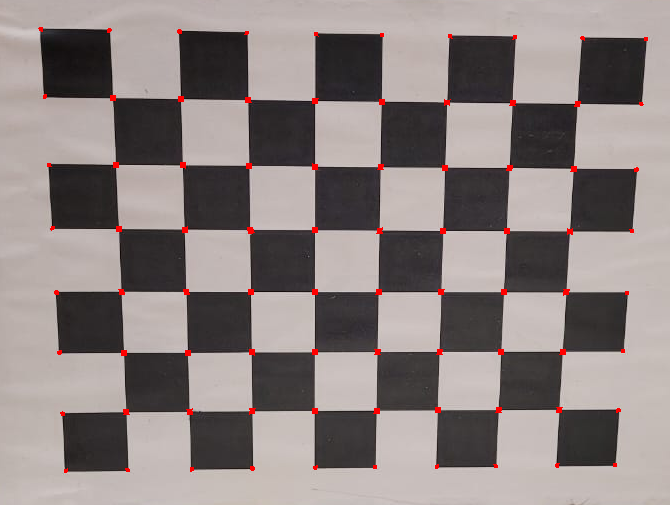

In [9]:
img_manual = np.copy(img)
corners = harris_corner_detection(img_manual, k=0.4, window_size=5) # takes half a minute

# Analysis:
It can be seen that the performance of the algorithm of the Harris corner detector is very good, it detects all the corners of the checkerboard whether internal corners or corners at the boundaries.

Compared to the baseline, it's as consistant as the built-in Harris detector function from the Open-CV library where the results of the two look identical.

It can be noticed that the interior conrners of the checkerboard (dots in red) are thicker than the corners at the boundaries, this is the case because on a checkerboard, interior corners have two strong edges in both x and y directions, so the response spreads out more. In addition that Harris corner detector computes a score (the Harris response) at every pixel based on gradient changes in a window, where two strong, perpendicular edges meet, the response is high across a small neighborhood, not just one pixel.


